In [2]:
import json
import os
import sys
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
from pathlib import Path

parent_dir = os.path.abspath('../../')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from utils.image_handling import crop_image, pad_bbox
from utils.keypoints import crop_and_resize_keypoints
from utils.heatmap import generate_multi_gaussian_heatmaps, decode_heatmaps

In [3]:
BASE_PATH = Path("../../")

In [4]:
def load_sample(sample_path):
    with open(sample_path, 'r') as f:
        samples = json.load(f)
    return samples

In [5]:
def prepare_cropped_image(sample_entry, target_size=(128, 128), use_saved_crops=True):
    bbox =  pad_bbox(sample_entry['bbox_obj'])

    if use_saved_crops:
        rgb_path = f"data/crops/{sample_entry['obj_id']:06d}/{sample_entry['image_id']}.png"
        resized_img = cv2.imread(BASE_PATH / str(rgb_path))
        resized_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)

    else:   
        rgb_path = Path(sample_entry['rgb_path'].replace('\\', '/'))
        img = cv2.imread(BASE_PATH / str(rgb_path))
        if img is None:
            raise FileNotFoundError(f"Image not found: {rgb_path}")
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # # Crop using bbox_obj
        cropped_img = crop_image(img_rgb, bbox)

        # Resize cropped image
        resized_img = cv2.resize(cropped_img, target_size, interpolation=cv2.INTER_LINEAR)

    # Adjust keypoints relative to crop
    keypoints_2D = np.array(sample_entry['keypoints_2D'])
    keypoints_2D_resized = crop_and_resize_keypoints(keypoints_2D, bbox, target_size=target_size)

    return resized_img, keypoints_2D_resized, sample_entry['image_id']

In [6]:
def visualize_multiple_samples(samples):
    fig, axes = plt.subplots(2, len(samples), figsize=(5 * len(samples), 10))

    if len(samples) == 1:
        axes = [axes]

    for i, sample_entry in enumerate(samples):
        resized_img, keypoints_2D_resized, image_id = prepare_cropped_image(sample_entry)

        # First row: original cropped images with keypoints
        axes[0, i].imshow(resized_img)
        axes[0, i].axis('off')
        text_offset = 2
        for idx, (x_kp, y_kp) in enumerate(keypoints_2D_resized):
            axes[0, i].scatter(x_kp, y_kp, c='red', s=40)
            axes[0, i].text(x_kp +   text_offset, y_kp -   text_offset, str(idx), color='blue', fontsize=8)
        axes[0, i].set_title(f"Image ID: {image_id}")

        # Second row: corresponding heatmap
        heatmaps = generate_multi_gaussian_heatmaps(keypoints_2D_resized, H=128, W=128, sigma=5)
        axes[1, i].imshow(heatmaps.sum(axis=0), cmap='jet')
        axes[1, i].axis('off')
        axes[1, i].set_title(f"Heatmap {image_id}")

    plt.tight_layout()
    plt.show()

In [7]:
def validate_from_saved_heatmaps(obj_id, image_id):
    heatmap_path = BASE_PATH / f"data/heatmaps/{obj_id:06d}/{image_id}.npz"
    if not heatmap_path.exists():
        print(f"Missing heatmap for {image_id}")
        return None, None, None

    data = np.load(heatmap_path)

    heatmaps = data['heatmaps']
    gt_keypoints = data['keypoints']

    decoded_keypoints = decode_heatmaps(heatmaps)

    error = np.linalg.norm(decoded_keypoints - gt_keypoints, axis=1).max()

    return heatmaps, gt_keypoints, decoded_keypoints, error

In [8]:
def validate_multiple_heatmaps(samples):
    errors = []
    visuals = []

    for sample in samples:
        obj_id = sample['obj_id']
        image_id = sample['image_id']
        heatmaps, gt_keypoints, decoded_keypoints, error = validate_from_saved_heatmaps(obj_id, image_id)
        if heatmaps is not None:
            errors.append(error)
            visuals.append((heatmaps, gt_keypoints, decoded_keypoints, obj_id, image_id))

    if errors:
        avg_error = np.mean(errors)
        print(f"Validated {len(errors)} samples. Overall average decoding error: {avg_error:.2f} pixels")

        # Multi-plot side by side
        fig, axes = plt.subplots(2, len(visuals), figsize=(5 * len(visuals), 10))

        for i, (heatmaps, gt_keypoints, decoded_keypoints, obj_id, image_id) in enumerate(visuals):
            # Heatmap visualization
            axes[0, i].imshow(heatmaps.sum(axis=0), cmap='hot')
            axes[0, i].axis('off')
            axes[0, i].set_title(f"OBJ {obj_id} ID {image_id}")

            # Keypoints visualization
            axes[1, i].imshow(heatmaps.sum(axis=0), cmap='jet')
            axes[1, i].scatter(gt_keypoints[:, 0], gt_keypoints[:, 1], c='blue', label='GT', s=50, marker='x')
            axes[1, i].scatter(decoded_keypoints[:, 0], decoded_keypoints[:, 1], c='red', label='Decoded', s=30, marker='o')
            axes[1, i].axis('off')

        plt.tight_layout()
        plt.show()

    else:
        print("No valid samples found.")

In [24]:
obj_id = 8  # Change as needed
sample_path = BASE_PATH / f"data/annotations/{obj_id:06d}.json"
samples = load_sample(sample_path)

# Randomly select 3 samples
random.seed(4)
selected_samples = random.sample(samples, 6)


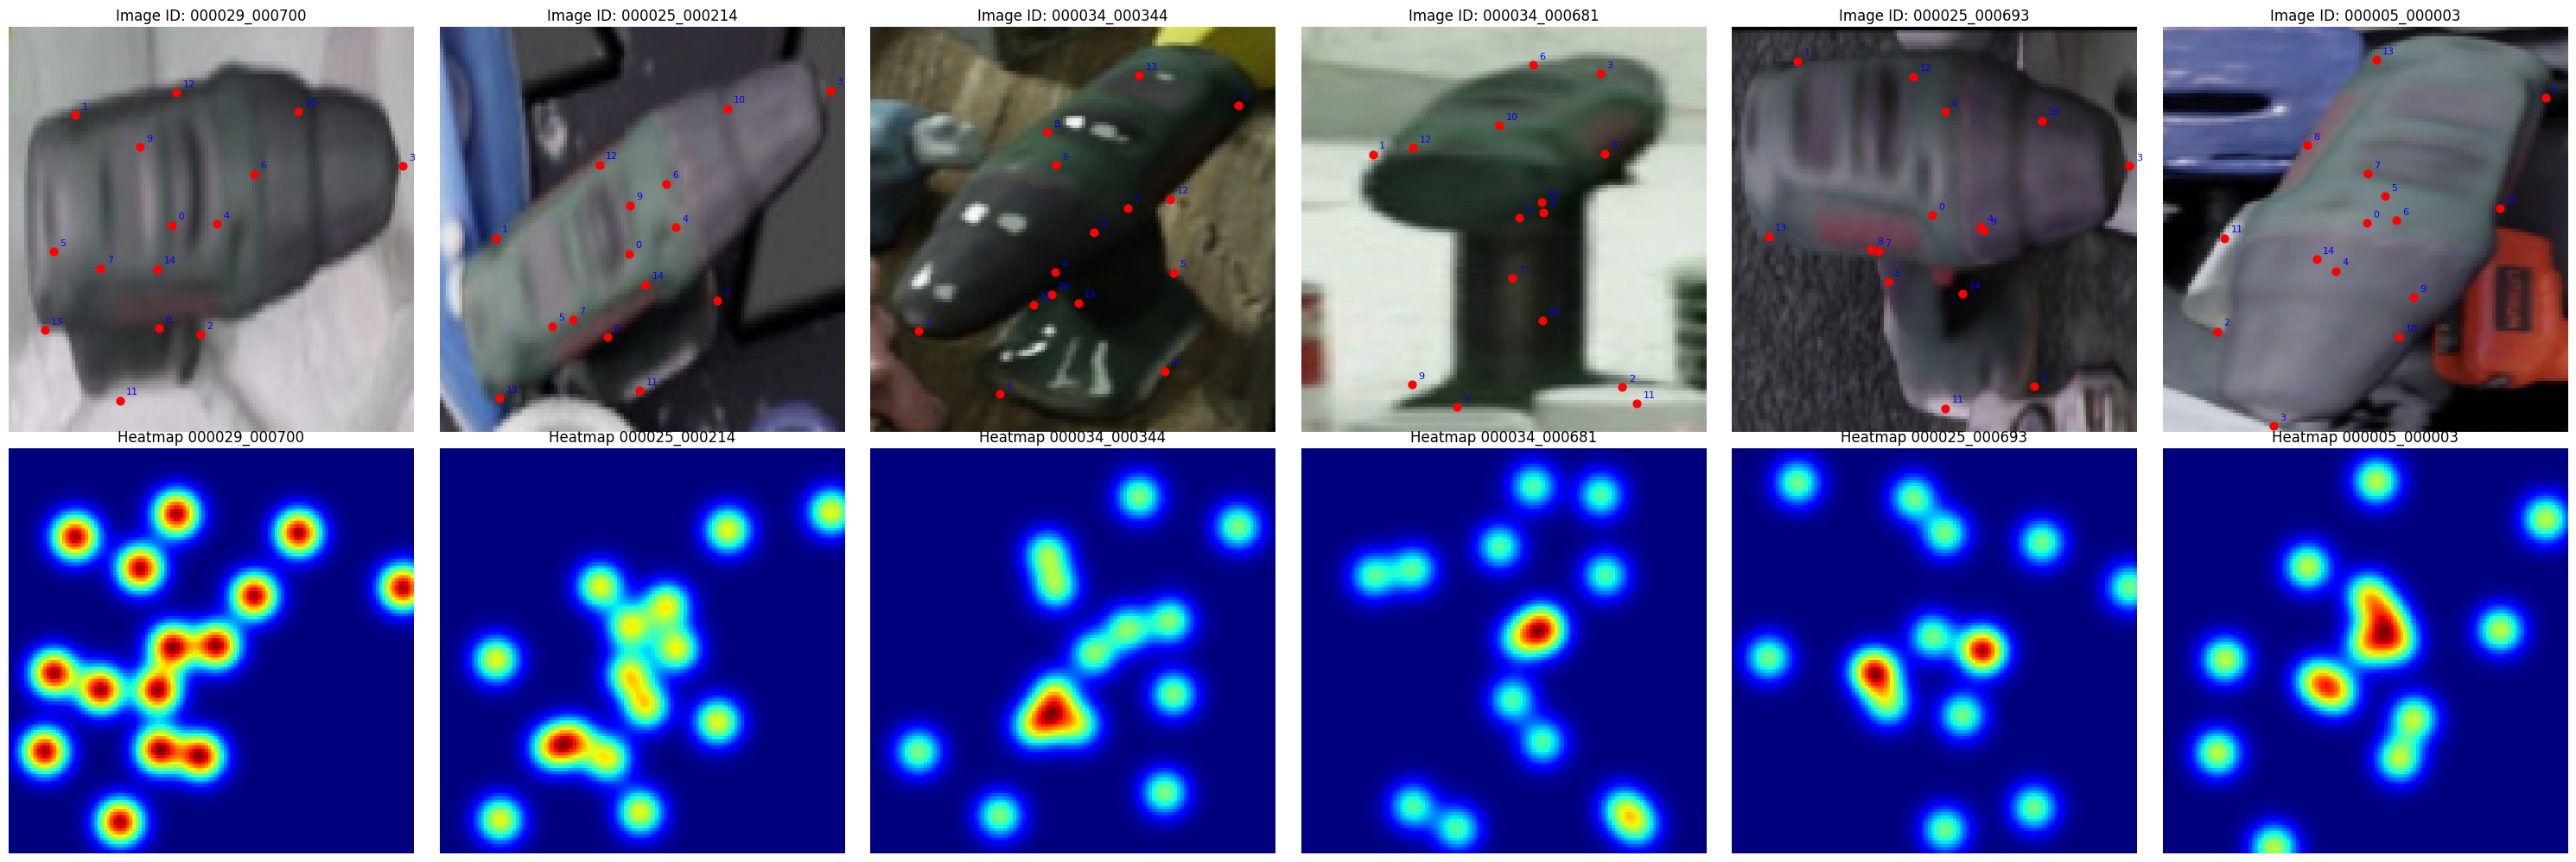

In [25]:
visualize_multiple_samples(selected_samples)

Validated 6 samples. Overall average decoding error: 0.60 pixels


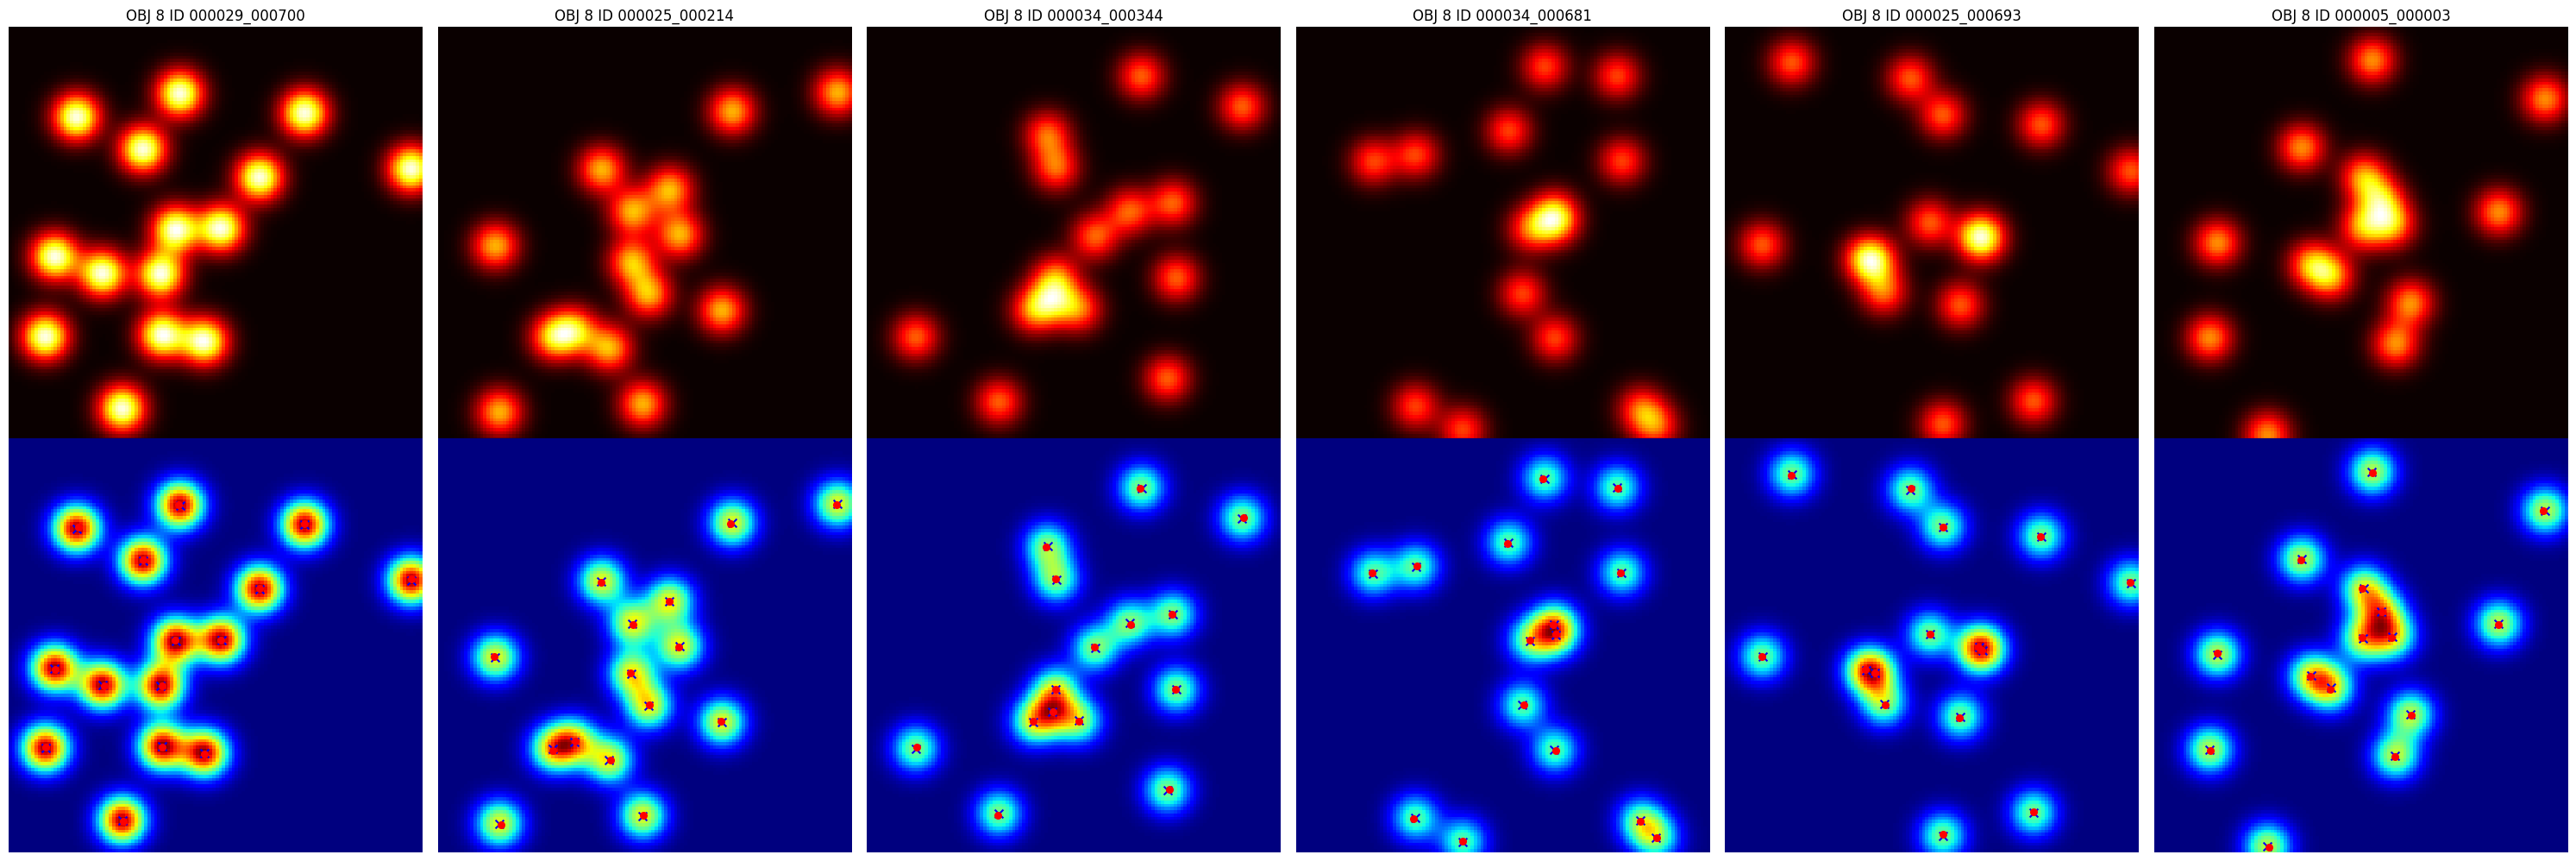

In [26]:
validate_multiple_heatmaps(selected_samples)